# HDC model training notebook 

Steps:
- load raw data 
- generate configs (hyper parameter)
- do cross validation to find the best configs (hyper parameters)
- train the model with the best hyperparameters in entire data from cross validation step 
- evaluate the model with test data (not included in cross validation train/val set)
- save the model and result

Note:
in this notebook, the final performance of the model is evaluated with test data.


In [33]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu


In [34]:
MODEL_NAME='HDC_balanced_UNDERSAMPLING_TWEAKED'

In [35]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm
from scipy import stats
from scipy.special import softmax
import random
import builtins
import torch
import torch.nn as nn
import torch.nn.functional as F
#Use local Executorch compatible copy of TorchHD
import os
sys.path.insert(0, os.path.abspath("../../../torchhd"))
sys.path.insert(0, os.path.abspath("../../../torchhd/torchhd"))
import torchhd
from torchhd import embeddings
from torchhd import models
print(torchhd.__file__) #Check
print(embeddings.__file__) #Check
print(models.__file__) #Check
from typing import Union, Literal
import json 
import pickle
# import torchmetrics
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.metrics import (
    mean_squared_error,
    median_absolute_error,
    r2_score,
    average_precision_score,
)
import warnings
from sklearn.preprocessing import StandardScaler
import gc
import time
from datetime import datetime
import logging
from tqdm import tqdm
from IPython.display import display
import os
from glob import glob
import polars as pl 
warnings.filterwarnings("ignore")


random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [36]:
import sys, os

# Remove torchhd if already loaded
if "torchhd" in sys.modules:
    del sys.modules["torchhd"]

# Point to the actual package folder (the one with __init__.py)
sys.path.insert(0, os.path.abspath("/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd"))

# Now import
import torchhd
from torchhd import embeddings, models

# Sanity check
print(torchhd.__file__)
assert hasattr(models.Centroid, "add_adjust"), "Custom torchhd still not loaded correctly"


In [37]:
hasattr(models.Centroid, "add_adjust")

True

In [38]:
RAW_COLUMNS = ['user_id', 'ZTIME', 'ZVALUEX_acc', 'ZVALUEY_acc', 
               'ZVALUEZ_acc', 'ZVALUEX_gyro', 'ZVALUEY_gyro', 'ZVALUEZ_gyro', 'ZHEARTRATE', 'ZAVERAGEHEARTRATE', 
              'tac (ug/L)', 'tac_flg', 'session_id']

TAC_THRESHOLD = 35
TAC_LEVEL_0 = 0
TAC_LEVEL_1 = 1
NUM_TAC_LEVELS = 2

ALL_USERS = [ 6,  9, 10, 11, 14, 15, 16, 24, 25, 26, 28, 31]

TRAIN_USERS = [[9, 10, 14, 15, 24, 28, 31],
[10, 11, 6, 31],
[6, 9, 11, 14, 15, 24, 28]]


VALID_USERS = [[11, 6],
[9, 14, 15, 24, 28],
[10, 31]]

TEST_USERS = [16,25,26]

# base config 
BASE_CONFIGS = {
    "device": "mps" if torch.backends.mps.is_available() else "cpu",
    "window_size": [40*20],
    "ngrams": [7],
    "hdc_dimension": 5000,
    "batch_size": [64],
    "learning_rate": [2],
    "epochs": 10,
    "patience": 5, # early stopping
    "overlap_ratio": 0.5,
}

In [39]:
### ADDED TWEAKS
def add_noise(seq, level=0.01):
    return seq + np.random.normal(0, level, seq.shape)

def drift_signal(seq, max_shift=0.1):
    drift = np.random.uniform(-max_shift, max_shift, (1, seq.shape[1]))
    return seq + drift
def time_shift(seq, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(seq, shift, axis=0)
def mixup(seq1, seq2, alpha=0.3):
    return alpha * seq1 + (1 - alpha) * seq2


In [40]:
def load_data(preprocess_fld='../../Preprocessed_all'):
    file_paths = sorted(glob(preprocess_fld + '/after_preprocess_group*.csv'))
    df_final = [pl.read_csv(file_path, columns=RAW_COLUMNS) for file_path in file_paths]
    columns = df_final[-1].columns
    df_final = pl.concat([data_df[columns] for data_df in df_final])
    df_final = df_final.filter(df_final['user_id'].is_in(ALL_USERS))

    # Rebuild session_id
    df_final = (
        df_final.with_columns([
            pl.concat_str([
                pl.col('user_id').cast(pl.Utf8),
                pl.lit('_'),
                pl.col('session_id')
            ]).alias('combined_key')
        ])
        .with_columns([
            pl.col('combined_key').rank(method='dense').cast(pl.Int32).alias('session_id')
        ])
        .drop('combined_key')
    )

    # # Fix: invert labels – 1 = sober → 0, 0 = drunk → 1
    # df_final = df_final.with_columns(
    #     pl.col('tac_flg').cast(float).map_elements(lambda x: 1.0 - x).alias('tac_flg')
    # )

    return df_final.to_pandas()


In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels, window_size=10):
        self.features = features
        self.labels = labels
        self.window_size = window_size

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.features[idx]),
            torch.FloatTensor([self.labels[idx]]),
        )

class HdcGenericEncoder(torch.nn.Module):
    def __init__(self, input_size: int, out_dimension: int, ngrams: int = 5, dtype = torch.float32, device : str = "cpu"):
        super(HdcGenericEncoder, self).__init__()

        #Embeddings for raw data
        self.input_size = input_size
        self.keys = embeddings.Random(input_size, out_dimension, dtype=dtype, device=device)
        self.motion_embed = embeddings.Level(3000, out_dimension, dtype=dtype, 
                                      low=-3.0, high=3.0, device=device)
        self.hr_embed = embeddings.Level(200, out_dimension, dtype=dtype, 
                                      low=50, high=200, device=device)
        self.ngrams = ngrams
        self.device = device
        self.dtype = dtype

    def batch_generic(self, id, levels, ngram):
        batch_size = levels.shape[0]
        multiset_list = []
        for b in range(batch_size):
            level = levels[b]
            b_levels = [
                torchhd.ngrams(level[0][i : i + ngram], ngram)
                for i in range(1, id.shape[0] - ngram + 1)
            ]
            if len(b_levels) > 0:
                b_levels = torch.stack(b_levels)
                multiset_list.append(torchhd.multiset(torchhd.bind(id[:-ngram], b_levels)).unsqueeze(0))
            else:
                multiset_list.append(torchhd.multiset(torchhd.bind(id, level)))
        return torch.stack(multiset_list)

    # Encode window
    def forward(self, channels: torch.Tensor) -> torch.Tensor:
        batch_size, window_size, num_channels = channels.shape
        motion_signals = channels[:, :, : self.input_size - 1]
        hr_signals = channels[:, :, self.input_size - 1].unsqueeze(-1)
        
        # Use generic encoder
        enc_motion_channels = self.motion_embed(motion_signals)
        enc_hr_channel = self.hr_embed(hr_signals)
        enc_channels = torch.cat([enc_motion_channels, enc_hr_channel], dim = 2)
        sample_hvs = self.batch_generic(
            self.keys.weight, enc_channels, self.ngrams
        )
        sample_hv = torchhd.multiset(sample_hvs)

        sample_hv = torchhd.hard_quantize(sample_hv)
        
        return sample_hv
    
    
class HdcModel(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        out_dimension: int,
        ngrams: int = 5,
        dtype=torch.float32,
        device: str = "cpu",
    ):
        super(HdcModel, self).__init__()
        
        self.encoder = HdcGenericEncoder(input_size, out_dimension, ngrams=ngrams, dtype=dtype, device=device)
        self.centroid = models.Centroid(
                out_dimension,
                NUM_TAC_LEVELS,
                dtype=dtype,
                device=device,
            )
        self.device = device
        self.dtype = dtype

    def add(self, x : torch.Tensor, y : torch.Tensor, lr : float):
        hv = self.encoder(x)
        labels = y.to(dtype=torch.int64)
        for i in range(len(hv)):
            #This operations can't be done in batches
            self.centroid.add_adjust(
                    hv[i].unsqueeze(0), labels[i], lr=lr
                )
            
    def adjust_reset(self):
        self.centroid.adjust_reset()
        
    #Executorch safe (0.6.x)
    def vector_norm(self, x, p=2, dim=None, keepdim=False):
        return torch.pow(torch.sum(torch.abs(x) ** p, dim=dim, keepdim=keepdim), 1 / p)
        
    def normalized_inference(self, input: torch.Tensor, dot: bool = False):
        normalized_weight = self.centroid.weight.detach().clone()
        norms = self.vector_norm(normalized_weight, p=2, dim=1, keepdim=True)
        norms.clamp_(min=1e-12)
        normalized_weight.div_(norms)

        if dot:
            return torchhd.functional.dot_similarity(input, normalized_weight)
        return torchhd.functional.cosine_similarity(input, normalized_weight)
        
    def binary_hdc_output(self, outputs):
        probs = F.softmax(outputs, dim=1)  # Shape: (batch_size, 2)
        return probs[:, 1]  # Extract only class 1 probability
        
    def forward(self, x : torch.Tensor):
        hv = self.encoder(x)
        output = self.normalized_inference(hv, True)

        return self.binary_hdc_output(output)

from sklearn.utils import resample

def prepare_sequences_undersampled(df, window_size=10, overlap_ratio=0.1, feature_columns=None):
    """
    Generate sequences and apply undersampling to balance class distribution.
    """
    session_user_map = pd.Series(df["user_id"].values, index=df["session_id"]).astype(int).to_dict()
    if feature_columns is None:
        feature_columns = [
            "ZVALUEX_acc",
            "ZVALUEY_acc",
            "ZVALUEZ_acc",
            "ZVALUEX_gyro",
            "ZVALUEY_gyro",
            "ZVALUEZ_gyro",
            "ZHEARTRATE",
        ]

    print(f"Preparing sequences with undersampling...")

    features = df[feature_columns].values
    labels = df["tac_flg"].values
    session_ids = df["session_id"].values
    unique_sessions = np.unique(session_ids)

    sequences = []
    sequence_labels = []
    sequence_user_ids = []

    for session_id in tqdm(unique_sessions):
        session_mask = session_ids == session_id
        session_indices = np.where(session_mask)[0]

        if len(session_indices) >= window_size:
            for start_idx in range(0, len(session_indices) - window_size + 1, int(window_size * overlap_ratio)):
                window_indices = session_indices[start_idx : start_idx + window_size]
                if len(window_indices) < window_size:
                    continue

                sequence = features[window_indices]
                label = int(stats.mode(labels[window_indices].astype(int), keepdims=False).mode)

                sequences.append(sequence)
                sequence_labels.append(label)
                sequence_user_ids.append(session_user_map[session_id])

    sequences = np.array(sequences)
    sequence_labels = np.array(sequence_labels)
    sequence_user_ids = np.array(sequence_user_ids)

    # === Undersample the majority class (label == 1)
    print("Balancing sequences via undersampling...")

    sober_mask = sequence_labels == 1
    drunk_mask = sequence_labels == 0

    sober_seqs = sequences[sober_mask]
    sober_labels = sequence_labels[sober_mask]
    sober_users = sequence_user_ids[sober_mask]

    drunk_seqs = sequences[drunk_mask]
    def augment_drunk(seqs, labels, users, n_aug=1):
        new_seqs, new_labels, new_users = [], [], []
        for i in range(len(seqs)):
            for _ in range(n_aug):
                aug_seq = add_noise(seqs[i], level=0.01)
                new_seqs.append(aug_seq)
                new_labels.append(labels[i])
                new_users.append(users[i])
        return (
            np.concatenate([seqs, np.stack(new_seqs)]),
            np.concatenate([labels, new_labels]),
            np.concatenate([users, new_users]),
        )

    
    drunk_labels = sequence_labels[drunk_mask]
    drunk_users = sequence_user_ids[drunk_mask]
    
    drunk_seqs, drunk_labels, drunk_users = augment_drunk(drunk_seqs, drunk_labels, drunk_users, n_aug=1)
    if len(drunk_seqs) == 0 or len(sober_seqs) == 0:
        raise ValueError("Insufficient class samples for undersampling.")

    undersample_ratio = 1  # or test 1.2, 1.3...
    n_samples = min(len(sober_seqs), int(len(drunk_seqs) * undersample_ratio))


    from sklearn.model_selection import StratifiedShuffleSplit

    if len(sober_seqs) > n_samples:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=(len(sober_seqs) - n_samples), random_state=42)
        idxs_to_keep, _ = next(sss.split(sober_seqs, sober_users))
        sober_seqs_resampled = sober_seqs[idxs_to_keep]
        sober_labels_resampled = sober_labels[idxs_to_keep]
        sober_users_resampled = sober_users[idxs_to_keep]
    else:
        # Not enough to subsample, just keep all
        sober_seqs_resampled = sober_seqs
        sober_labels_resampled = sober_labels
        sober_users_resampled = sober_users



    # Combine and shuffle
    sequences_balanced = np.concatenate([sober_seqs_resampled, drunk_seqs])
    labels_balanced = np.concatenate([sober_labels_resampled, drunk_labels])
    users_balanced = np.concatenate([sober_users_resampled, drunk_users])

    indices = np.arange(len(labels_balanced))
    np.random.shuffle(indices)

    sequences_balanced = sequences_balanced[indices]
    labels_balanced = labels_balanced[indices]
    users_balanced = users_balanced[indices]

    print(f"Undersampled sequence shape: {sequences_balanced.shape}")

    return sequences_balanced, labels_balanced, users_balanced

def prepare_sequences_fast(df, window_size=10, overlap_ratio=0.1, feature_columns=None):
        session_user_map = pd.Series(df["user_id"].values, index=df["session_id"]).astype(int).to_dict()
        if feature_columns is None:
            feature_columns = [
                "ZVALUEX_acc",
                "ZVALUEY_acc",
                "ZVALUEZ_acc",
                "ZVALUEX_gyro",
                "ZVALUEY_gyro",
                "ZVALUEZ_gyro",
                "ZHEARTRATE",
            ]

        print(f"Starting sequence preparation...")

        # 特徴量とラベルを事前にNumPy配列に変換
        features = df[feature_columns].values
        labels = df["tac_flg"].values
        session_ids = df["session_id"].values

        # セッションのユニークなIDと各セッションのインデックスを取得
        unique_sessions = np.unique(session_ids)
        print(f"Processing {len(unique_sessions)} sessions...")

        sequences = []
        sequence_labels = []
        sequence_user_ids = []

        for session_id in tqdm(unique_sessions):
            session_mask = session_ids == session_id
            session_indices = np.where(session_mask)[0]

            if len(session_indices) >= window_size:
                for start_idx in range(
                    0, len(session_indices) - window_size + 1, np.ceil(window_size*overlap_ratio).astype(int)
                ):
                    window_indices = session_indices[start_idx : start_idx + window_size]
                    if len(window_indices) < window_size:
                        continue

                    sequence = features[window_indices]
                    # get the mode label in the current window
                    label = stats.mode(labels[window_indices].astype(int))[0]

                    sequences.append(sequence)
                    sequence_labels.append(label)
                    sequence_user_ids.append(session_user_map[session_id])

        sequences = np.array(sequences)
        sequence_labels = np.array(sequence_labels)

        print(f"Created {len(sequences)} sequences")
        print(f"Sequences shape: {sequences.shape}")

        return sequences, sequence_labels, sequence_user_ids


def validate_model(model, valid_loader, criterion, device):
    """検証データでのモデル評価"""
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.squeeze(-1))
            val_loss += loss.item()

            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(batch_y.squeeze(-1).cpu().numpy())

    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)

    val_prauc = average_precision_score(val_labels, val_preds)
    val_rocauc = roc_auc_score(val_labels, val_preds)

    return {
        "loss": val_loss / len(valid_loader),
        "pr_auc": val_prauc,
        "roc_auc": val_rocauc,
    }


def train_model(
    model : HdcModel,
    train_loader,
    valid_loader,
    criterion,
    lr,
    device,
    epochs=100,
    patience=5,
):
    best_val_prauc = 0
    patience_counter = 0
    best_train_epoch = 0
    best_model_state = None
    training_history = []

    print(
        "Epoch | Train Loss |  Val Loss  |  Val PR-AUC  |  Val ROC-AUC  |  Epoch Time (s)"
    )
    print("-" * 85)

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            model.add(batch_X, batch_y, lr)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.squeeze(-1))

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        epoch_time = time.time() - start_time
        
        model.adjust_reset()

        if valid_loader is None:
            epoch_results = {"epoch": epoch + 1, "train_loss": train_loss, "time": epoch_time}
            training_history.append(epoch_results)
            print(f"{epoch+1:5d} | {train_loss:.6f} | ------ | ------ | {epoch_time:.2f}")
            continue
    
        val_metrics = validate_model(model, valid_loader, criterion, device)
        epoch_results = {"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_metrics["loss"], 
                         "val_pr_auc": val_metrics["pr_auc"], "val_roc_auc": val_metrics["roc_auc"], "time": epoch_time}
        training_history.append(epoch_results)

        print(
            f"{epoch+1:5d} | {train_loss:.6f} | {val_metrics['loss']:.6f} | "
            f"{val_metrics['pr_auc']:.4f} | {val_metrics['roc_auc']:.4f} | "
            f"{epoch_time:.2f}"
        )
        
        if val_metrics["pr_auc"] >= best_val_prauc:
            best_val_prauc = val_metrics["pr_auc"]
            best_model_state = model.state_dict()
            patience_counter = 0
            best_train_epoch = epoch
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            print(f"Best validation PR-AUC: {best_val_prauc:.4f}")
            break

    if best_model_state is not None: 
        model.load_state_dict(best_model_state)
    return model, training_history, best_train_epoch


def inference_dataset(model, data_loader, device, pred_threshold=None):
    """evaluation model after a fold training"""
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            labels.extend(batch_y.squeeze(-1).cpu().numpy())

    pred_prob = np.array(predictions)
    gt_labels = np.array(labels)
    return pred_prob, gt_labels


def performance_calculation(pred_prob, gt_label, threshold=None):
    '''
    Calculate the performance of the model
    Args:
    pred_prob: list, predicted probability
    gt_label: list, ground truth label
    threshold: float, threshold for binary classification (None if we are evaluating on train data)
    '''
    if threshold is None:
        # Find the optimal threshold by maximizing F1 score
        thresholds = np.linspace(0.01, 0.99, 99)  # Test 99 threshold values
        best_f1 = 0
        best_threshold = 0.5  # Default if no better threshold is found
        
        for t in thresholds:
            temp_pred = (pred_prob >= t).astype(int)
            temp_f1 = (f1_score(gt_label, temp_pred, pos_label=0) + f1_score(gt_label, temp_pred, pos_label=1)) / 2

            
            if temp_f1 > best_f1:
                best_f1 = temp_f1
                best_threshold = t
        
        threshold = best_threshold
        
    pred_label = (pred_prob >= threshold).astype(int)
    roc_auc = roc_auc_score(gt_label, pred_prob)
    pr_auc = average_precision_score(gt_label, pred_prob)
    accuracy = accuracy_score(gt_label, pred_label)

    # Since 0 = drunk and 1 = sober
    drunk_acc = accuracy_score(gt_label[gt_label == 0], pred_label[gt_label == 0])
    sober_acc = accuracy_score(gt_label[gt_label == 1], pred_label[gt_label == 1])

    f1 = f1_score(gt_label, pred_label)
    return roc_auc, pr_auc, accuracy, sober_acc, drunk_acc, f1, threshold


def generate_configs(base_config):
    """
    Generate multiple configurations from a base config.
    For any list values in the base config, create a separate config for each list item.
    
    Args:
        base_config (dict): Base configuration with potential list values
        
    Returns:
        list: List of individual configurations
    """
    # Find all keys with list values
    list_keys = [key for key, value in base_config.items() if isinstance(value, list)]
    
    if not list_keys:
        # If no list values found, return the original config
        return [base_config]
    
    # Start with the first list key
    key = list_keys[0]
    values = base_config[key]
    
    # Generate configurations for each value of the first list key
    configs = []
    for value in values:
        # Create a new config with this specific value
        new_config = base_config.copy()
        new_config[key] = value
        
        # Recursively handle any remaining list keys
        remaining_configs = generate_configs(new_config)
        configs.extend(remaining_configs)
    
    return configs

In [42]:
def save_model_and_results(model, save_folder, train_preds, train_gt_labels, test_preds, test_gt_labels, metrics, config):
    """
    Save model, predictions, ground truth, metrics, and model structure to the specified folder.
    
    Args:
        model: The trained model
        save_folder: Folder path to save results
        train_preds: Training predictions
        train_gt_labels: Training ground truth labels
        test_preds: Test predictions
        test_gt_labels: Test ground truth labels
        metrics: Dictionary containing evaluation metrics
        config: Model configuration dictionary
    """
    # Create a timestamp for the save files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save the model
    model_path = os.path.join(save_folder, f"model_{timestamp}.pt")
    torch.save(model.state_dict(), model_path)
    
    # Save model architecture as text
    model_structure_path = os.path.join(save_folder, f"model_structure_{timestamp}.txt")
    with open(model_structure_path, 'w') as f:
        f.write(str(model))
    
    # Save predictions and ground truth
    predictions_data = {
        'train_predictions': train_preds.tolist() if isinstance(train_preds, np.ndarray) else train_preds,
        'train_ground_truth': train_gt_labels.tolist() if isinstance(train_gt_labels, np.ndarray) else train_gt_labels,
        'test_predictions': test_preds.tolist() if isinstance(test_preds, np.ndarray) else test_preds,
        'test_ground_truth': test_gt_labels.tolist() if isinstance(test_gt_labels, np.ndarray) else test_gt_labels
    }
    pred_path = os.path.join(save_folder, f"predictions_{timestamp}.pkl")
    with open(pred_path, 'wb') as f:
        pickle.dump(predictions_data, f)
    
    # Save all metrics
    metrics_path = os.path.join(save_folder, f"metrics_{timestamp}.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Save the configuration
    config_path = os.path.join(save_folder, f"config_{timestamp}.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"Model, predictions, ground truth, and metrics saved in {save_folder}")


def train_and_eval_final_model(best_config, best_threshold, df):
    print('\nBEGIN TRAIN AND EVALUATION FINAL MODEL\n')
    feature_columns = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        "ZHEARTRATE",
    ]

    # Hyper parameter loading
    device = best_config['device'] 
    window_size = best_config['window_size']
    input_size = len(feature_columns)
    batch_size = best_config['batch_size']
    hdc_dimension = best_config['hdc_dimension']
    ngrams = best_config['ngrams']
    learning_rate = best_config['learning_rate']
    epochs = best_config['epochs']
    patience = best_config['patience']
    runtime_log_fld = best_config['runtime_log_fld']
    overlap_ratio = best_config['overlap_ratio']
    
    train_user = list(set(ALL_USERS)- set(TEST_USERS))
    test_user = TEST_USERS
        
    train_data = df[df['user_id'].isin(train_user)]
    test_data = df[df['user_id'].isin(test_user)]
    # columns will be normalized
    columns_to_standardize = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        #'ZHEARTRATE'
    ]

    # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
    scaler = StandardScaler()
    train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
    test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

    print("Preparing sequences...")
    X_train, y_train, train_user_ids = prepare_sequences_undersampled(train_data, window_size, overlap_ratio)
    X_test, y_test, test_user_ids = prepare_sequences_fast(test_data, window_size, overlap_ratio)


    print(f"Users in train:{set(train_data['user_id'])}")
    print(f"Users in test:{set(test_data['user_id'])}")
    print(f"Number of windows for training:{len(X_train)}")
    print(f"Number of windows for testing:{len(X_test)}")

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = HdcModel(input_size, hdc_dimension, ngrams, device=device)

    criterion = nn.BCELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 02. Train model (set patience to ensure that the model is trained for the best epoch)
    model, training_history, _ = train_model(
        model=model, train_loader=train_loader, valid_loader=None, 
        criterion=criterion, lr=learning_rate, device=device, epochs=epochs
    )

    # 03. Inference
    train_preds, train_gt_labels = inference_dataset(model, train_loader, device)
    test_preds, test_gt_labels = inference_dataset(model, test_loader, device)

    # 04. Calculate performance of current config: ROC, PR-AUC, ACC, F1, Drunk ACC, Sober ACC
    train_roc_auc, train_pr_auc, train_accuracy, train_sober_acc, train_drunk_acc, train_f1, train_threshold = performance_calculation(train_preds, train_gt_labels, threshold=best_threshold)
    print(f"Training ROC-AUC: {train_roc_auc:.4f}, PR-AUC: {train_pr_auc:.4f}, Accuracy: {train_accuracy:.4f}, Sober Accuracy: {train_sober_acc:.4f}, Drunk Accuracy: {train_drunk_acc:.4f}, F1: {train_f1:.4f}, Threshold: {train_threshold:.4f}")
    test_roc_auc, test_pr_auc, test_accuracy, test_sober_acc, test_drunk_acc, test_f1, test_threshold = performance_calculation(test_preds, test_gt_labels, threshold=best_threshold)
    print(f"Test ROC-AUC: {test_roc_auc:.4f}, PR-AUC: {test_pr_auc:.4f}, Accuracy: {test_accuracy:.4f}, Sober Accuracy: {test_sober_acc:.4f}, Drunk Accuracy: {test_drunk_acc:.4f}, F1: {test_f1:.4f}, Threshold: {test_threshold:.4f}")    

    # 05. Save model, predictions, ground truth, metrics and model structure
    metrics = {
        'train': {
            'roc_auc': train_roc_auc,
            'pr_auc': train_pr_auc,
            'accuracy': train_accuracy,
            'sober_accuracy': train_sober_acc,
            'drunk_accuracy': train_drunk_acc,
            'f1': train_f1,
            'threshold': train_threshold
        },
        'test': {
            'roc_auc': test_roc_auc,
            'pr_auc': test_pr_auc,
            'accuracy': test_accuracy,
            'sober_accuracy': test_sober_acc,
            'drunk_accuracy': test_drunk_acc,
            'f1': test_f1,
            'threshold': test_threshold
        },
        'config': best_config
    }
    
    # Call the function to save all results
    save_model_and_results(
        model=model,
        save_folder=runtime_log_fld,
        train_preds=train_preds,
        train_gt_labels=train_gt_labels,
        test_preds=test_preds,
        test_gt_labels=test_gt_labels,
        metrics=metrics,
        config=best_config
    )
    
    # refresh GPU
    model.to("cpu")
    del model
    gc.collect()
    
    return train_accuracy, test_accuracy, metrics

def train_cross_validation(df, all_configs):
    print("="*50 + "\nBEGIN CROSSVALIDATION\n" + "="*50)    
    best_config = None 
    best_pr_auc = 0
    best_threshold = 0.5 
    for config_idx, config in enumerate(all_configs):
        print(f"\nCONFIG {config_idx}: {config}\n")
        feature_columns = [
            "ZVALUEX_acc",
            "ZVALUEY_acc",
            "ZVALUEZ_acc",
            "ZVALUEX_gyro",
            "ZVALUEY_gyro",
            "ZVALUEZ_gyro",
            "ZHEARTRATE",
        ]

        # Hyper parameter loading
        device = config['device'] 
        window_size = config['window_size']
        input_size = len(feature_columns)
        batch_size = config['batch_size']
        hdc_dimension = config['hdc_dimension']
        ngrams = config['ngrams']
        learning_rate = config['learning_rate']
        epochs = config['epochs']
        overlap_ratio = config['overlap_ratio']
        patience = config['patience']

        # variables for temperary storing
        val_all_preds = []
        val_all_gt_labels = []
        val_trained_epoch = []

        for fold, (train_user, val_user) in enumerate(zip(TRAIN_USERS, VALID_USERS)):

            # 01. Prepare data and define model
            print("-" * 100)
            print('FOLD:', fold+1)
            print('TRAIN:', train_user)
            print('VAL:', val_user)
            
            train_data = df[df['user_id'].isin(train_user)].copy()
            val_data = df[df['user_id'].isin(val_user)].copy()

            # columns will be normalized
            columns_to_standardize = [
                "ZVALUEX_acc",
                "ZVALUEY_acc",
                "ZVALUEZ_acc",
                "ZVALUEX_gyro",
                "ZVALUEY_gyro",
                "ZVALUEZ_gyro",
                #'ZHEARTRATE'
            ]

            # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
            scaler = StandardScaler()
            train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
            val_data[columns_to_standardize] = scaler.transform(val_data[columns_to_standardize])

            print("Preparing sequences...")
            X_train, y_train, train_user_ids = prepare_sequences_undersampled(train_data, window_size, overlap_ratio)
            X_val, y_val, val_user_ids = prepare_sequences_undersampled(val_data, window_size, overlap_ratio)

            print(f"Users in train:{set(train_data['user_id'])}")
            print(f"Users in test:{set(val_data['user_id'])}")
            print(f"Number of windows for training:{len(X_train)}")
            print(f"Number of windows for testing:{len(X_val)}")

            train_dataset = TimeSeriesDataset(X_train, y_train)
            val_dataset = TimeSeriesDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            model = HdcModel(input_size, hdc_dimension, ngrams, device=device)

            criterion = nn.BCELoss()
            #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # 02. Train model 
            model, training_history, train_best_epoch = train_model(
                model, train_loader, val_loader, criterion, lr=learning_rate, device=device, 
                epochs=epochs, patience=patience
            )

            # 03. Inference
            val_preds, val_gt_labels = inference_dataset(model, val_loader, device)
            val_all_preds.append(val_preds)
            val_all_gt_labels.append(val_gt_labels)
            val_trained_epoch.append(train_best_epoch)

            # refresh GPU
            model.to("cpu")
            del model
            gc.collect()

        # 04. Calculate performance of current config: ROC, PR-AUC, ACC, F1, Drunk ACC, Sober ACC
        val_all_preds = np.concatenate(val_all_preds)
        val_all_gt_labels = np.concatenate(val_all_gt_labels)
        val_roc_auc, val_pr_auc, val_accuracy, val_sober_acc, val_drunk_acc, val_f1, val_threshold = performance_calculation(val_preds, val_gt_labels)
        print(f"Validation ROC-AUC: {val_roc_auc:.4f}, PR-AUC: {val_pr_auc:.4f}, Accuracy: {val_accuracy:.4f}, Sober Accuracy: {val_sober_acc:.4f}, Drunk Accuracy: {val_drunk_acc:.4f}, F1: {val_f1:.4f}, Threshold: {val_threshold:.4f}")
        
        # 05. set up best config
        if val_pr_auc > best_pr_auc:
            best_pr_auc = val_pr_auc
            best_config = config
            best_threshold = val_threshold
            best_config_epoch = np.ceil(np.mean(val_trained_epoch)) + 1
            print(f"Updated best config: {best_config}, PR-AUC: {best_pr_auc:.4f}, Threshold: {best_threshold:.4f}, Epoch: {best_config_epoch:.2f}")

    print("="*50)
    best_config['epochs'] = int(best_config_epoch)
    best_config['patience'] = int(best_config_epoch)
    print(f'Final best config: {best_config}, Final best pr_auc: {best_pr_auc}, Final best threshold: {best_threshold}, Final best epoch: {best_config_epoch}')
    print("="*50 + "\nEND CROSSVALIDATION\n" + "="*50)    
    return best_config, best_pr_auc, best_threshold



In [43]:
def setup_logging(log_file_path):
    # Configure logging
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
    # Remove existing handlers
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    
    # Add file handler
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    # Create a custom print function
    original_print = print
    
    def custom_print(*args, **kwargs):
        # Call original print
        # original_print(*args, **kwargs)
        # Log the printed content
        message = " ".join(str(arg) for arg in args)
        logger.info(f"PRINT: {message}")
    
    # Replace built-in print
    import builtins
    builtins.print = custom_print
    
    logger.info(f"Logging initialized to {os.path.abspath(log_file_path)}")
    return logger

In [44]:
def runtime():
    # 1.set up logging
    runtime_log_fld = f"results/{MODEL_NAME}/{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    if os.path.exists(runtime_log_fld) == False:
        os.makedirs(runtime_log_fld)
    logger = setup_logging(f"{runtime_log_fld}/training.log")
    
    # 2.set up configurations
    base_configs = BASE_CONFIGS
    base_configs['runtime_log_fld'] = runtime_log_fld   
    all_configs = generate_configs(base_configs)
    print(f"Total configurations: {len(all_configs)}")

    # 3.Load the raw data
    df = load_data()
    # columns will be normalized
    columns_to_standardize = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        #'ZHEARTRATE'
    ]

    # # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
    # scaler = StandardScaler()
    # df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    # 4. Train and evaluate all configurations
    # get the best config of current model 
    # get the best threshold of drunk or sober based on all fold validation data when using best config
    best_config, best_pr_auc, best_threshold = train_cross_validation(df, all_configs)

    # 5.Train and evaluate the final model with the best configuration
    # train the final model on all data in cross validation and evaluate on test data
    # calculate the performance and save the model, metrics and best config 
    train_and_eval_final_model(best_config, best_threshold, df)


In [45]:
runtime()

100%|██████████| 7/7 [00:00<00:00, 19.93it/s]


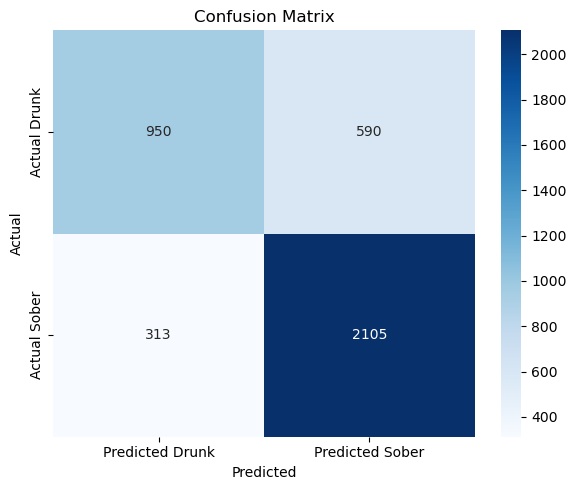

In [46]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from glob import glob
files = glob("results/HDC_balanced_UNDERSAMPLING_TWEAKED/20250423_130656/predictions_20250424_032714.pkl")
assert len(files) > 0, "No prediction files found!"
file_path = files[0]
with open(file_path, "rb") as f:
    predictions = pickle.load(f)


# Get raw test predictions and labels
test_probs = np.array(predictions["test_predictions"])
test_labels = np.array(predictions["test_ground_truth"])

# Use same threshold as during training
threshold = 0.31  # or dynamically extract it from your saved metrics

# Convert to binary predictions
test_binary_preds = (test_probs >= threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(test_labels, test_binary_preds)

# Print it
print("Confusion Matrix:")
print(cm)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Drunk", "Predicted Sober"],
            yticklabels=["Actual Drunk", "Actual Sober"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [47]:
predictions['test_predictions'][0]

0.8946428298950195

In [48]:
predictions['test_ground_truth'][0]

1.0

In [49]:
# Count class labels
from collections import Counter
test_label_counts = Counter(predictions["test_ground_truth"])
train_label_counts = Counter(predictions["train_ground_truth"])

print("Class counts in TEST set:")
for label, count in sorted(test_label_counts.items()):
    print(f"Label {int(label)}: {count}")

print("\nClass counts in TRAIN set:")
for label, count in sorted(train_label_counts.items()):
    print(f"Label {int(label)}: {count}")

In [50]:
train_label_counts

Counter({0.0: 47562, 1.0: 25831})

In [51]:
test_label_counts

Counter({1.0: 2418, 0.0: 1540})